In [40]:
%pip install torch torchvision torchaudio
%pip install roboflow
%pip install opencv-python matplotlib seaborn
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt
%cd ..

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


c:\Users\koryc\OneDrive\Pulpit\V-Aid-Climbing\ML-hold-detection\yolov5\yolov5


Cloning into 'yolov5'...


Note: you may need to restart the kernel to use updated packages.
c:\Users\koryc\OneDrive\Pulpit\V-Aid-Climbing\ML-hold-detection\yolov5


In [41]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from roboflow import Roboflow
from IPython.display import display, Image

In [42]:
def prepare_dataset(api_key):
    """Download and prepare the climbing holds dataset from Roboflow"""
    rf = Roboflow(api_key=api_key)
    project = rf.workspace("blackcreed-xpgxh").project("climbing-holds-and-volumes")
    dataset = project.version(14).download("yolov5")
    print(f"Dataset downloaded to {dataset.location}")
    return dataset.location

# 2. Explore dataset
def explore_dataset(dataset_path):
    """Display information about the dataset"""
    # Check yaml file
    import yaml
    with open(os.path.join(dataset_path, 'data.yaml'), 'r') as f:
        data_config = yaml.safe_load(f)
    
    print("Dataset Information:")
    print(f"- Number of classes: {len(data_config['names'])}")
    print(f"- Classes: {data_config['names']}")
    
    # Show sample images
    sample_img_path = os.path.join(dataset_path, 'train', 'images')
    sample_images = os.listdir(sample_img_path)[:3]  # Show first 3 images
    
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
    for i, img_name in enumerate(sample_images):
        img = cv2.imread(os.path.join(sample_img_path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
    return data_config

In [43]:
def train_model(dataset_path, epochs=50, img_size=640, batch_size=16, weights='yolov5s.pt'):
    """Train YOLOv5 model on the climbing holds dataset"""
    # Get current directory
    current_dir = os.getcwd()
    print(f"Starting directory: {current_dir}")
    
    # Check if we're already in yolov5 directory
    in_yolov5 = os.path.basename(current_dir) == 'yolov5'
    
    if in_yolov5:
        print("Already in YOLOv5 directory")
        # Path to data.yaml needs to be adjusted
        data_yaml_path = os.path.join('..', dataset_path, 'data.yaml')
    else:
        # Navigate to yolov5 directory
        print(f"Changing to YOLOv5 directory from {current_dir}")
        os.chdir('yolov5')
        # Standard path to data.yaml
        data_yaml_path = os.path.join('..', dataset_path, 'data.yaml')
    
    # Create the training command
    train_command = (
        f"python train.py "
        f"--img {img_size} "
        f"--batch {batch_size} "
        f"--epochs {epochs} "
        f"--data {data_yaml_path} "
        f"--weights {weights} "
        f"--cache"
    )
    
    print(f"Executing: {train_command}")
    os.system(train_command)
    
    # Return to original directory
    if not in_yolov5:
        os.chdir(current_dir)
    else:
        os.chdir('..')  # Go back to parent directory
    
    # Return the path to the best model
    best_model_path = os.path.join('yolov5', 'runs', 'train', 'exp', 'weights', 'best.pt')
    return best_model_path

In [44]:
def optimize_for_edge(model_path, img_size=640):
    """Optimize the trained model for edge deployment"""
    # Get current directory
    current_dir = os.getcwd()
    in_yolov5 = os.path.basename(current_dir) == 'yolov5'
    
    if not in_yolov5:
        os.chdir('yolov5')
    
    # Export to ONNX
    export_command = (
        f"python export.py "
        f"--weights {model_path} "
        f"--img {img_size} "
        f"--include onnx "
        f"--simplify"
    )
    
    print(f"Executing: {export_command}")
    os.system(export_command)
    
    # Return to original directory
    if not in_yolov5:
        os.chdir(current_dir)
    
    # Return path to the exported ONNX model
    onnx_path = model_path.replace('.pt', '.onnx')
    return onnx_path

In [45]:
# 5. Inference function
def detect_holds(model_path, image_path, conf_threshold=0.25, img_size=640):
    """Detect climbing holds in an image using the trained model"""
    # Set up model
    model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path)
    model.conf = conf_threshold  # Confidence threshold
    model.iou = 0.45  # IoU threshold
    model.classes = None  # All classes
    model.max_det = 1000  # Maximum detections
    model.agnostic = False  # NMS class-agnostic
    model.img_size = img_size  # Inference size
    
    # Run inference
    results = model(image_path)
    
    # Display results
    results.show()
    
    # Return results
    return results

In [46]:
# 6. Color-based feature extraction (demonstration for additional features)
def extract_color_features(image_path):
    """Extract color-based features from an image of climbing holds"""
    # Read image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Display original and HSV images
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Create a false-color representation of HSV for visualization
    hsv_visualization = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    axes[1].imshow(hsv_visualization)
    axes[1].set_title("HSV Representation")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Extract color histograms (example feature extraction)
    h_hist = cv2.calcHist([hsv], [0], None, [32], [0, 180])
    s_hist = cv2.calcHist([hsv], [1], None, [32], [0, 256])
    v_hist = cv2.calcHist([hsv], [2], None, [32], [0, 256])
    
    # Normalize histograms
    h_hist = cv2.normalize(h_hist, h_hist, 0, 1, cv2.NORM_MINMAX)
    s_hist = cv2.normalize(s_hist, s_hist, 0, 1, cv2.NORM_MINMAX)
    v_hist = cv2.normalize(v_hist, v_hist, 0, 1, cv2.NORM_MINMAX)
    
    # Plot histograms
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].plot(h_hist)
    axes[0].set_title("Hue Histogram")
    axes[1].plot(s_hist)
    axes[1].set_title("Saturation Histogram")
    axes[2].plot(v_hist)
    axes[2].set_title("Value Histogram")
    plt.tight_layout()
    plt.show()
    
    return {
        'hue_hist': h_hist.flatten(),
        'sat_hist': s_hist.flatten(),
        'val_hist': v_hist.flatten()
    }


In [47]:
# 7. Main function to run the entire pipeline
def run_climbing_hold_detection(api_key, epochs=50, train_new_model=True):
    """Run the complete climbing hold detection pipeline"""
    # Step 1: Prepare dataset
    print("Preparing dataset...")
    dataset_path = prepare_dataset(api_key)
    
    # Step 2: Explore dataset
    print("\nExploring dataset...")
    data_config = explore_dataset(dataset_path)
    
    # Step 3: Train model (or use pre-trained)
    if train_new_model:
        print("\nTraining model...")
        model_path = train_model(dataset_path, epochs=epochs)
        print(f"Model trained and saved to: {model_path}")
    else:
        # Use latest trained model if available
        model_path = os.path.join('yolov5', 'runs', 'train', 'exp', 'weights', 'best.pt')
        if not os.path.exists(model_path):
            print("No pre-trained model found. Please set train_new_model=True")
            return
        print(f"Using existing model: {model_path}")
    
    # Step 4: Optimize for edge deployment
    print("\nOptimizing model for edge deployment...")
    onnx_path = optimize_for_edge(model_path)
    print(f"Optimized model saved to: {onnx_path}")
    
    # Step 5: Run inference on a test image
    print("\nRunning inference on test image...")
    test_image_path = os.path.join(dataset_path, 'test', 'images', os.listdir(os.path.join(dataset_path, 'test', 'images'))[0])
    results = detect_holds(model_path, test_image_path)
    
    # Step 6: Extract additional features (demonstration)
    print("\nExtracting color features for additional analysis...")
    color_features = extract_color_features(test_image_path)
    
    print("\nDetection pipeline completed successfully!")
    return {
        'model_path': model_path,
        'onnx_path': onnx_path,
        'results': results,
        'color_features': color_features
    }

Current working directory: c:\Users\koryc\OneDrive\Pulpit\V-Aid-Climbing\ML-hold-detection
loading Roboflow workspace...
loading Roboflow project...
Preparing dataset...
loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded to c:\Users\koryc\OneDrive\Pulpit\V-Aid-Climbing\ML-hold-detection\Climbing-Holds-and-Volumes-14

Exploring dataset...
Dataset Information:
- Number of classes: 2
- Classes: ['0', '1']


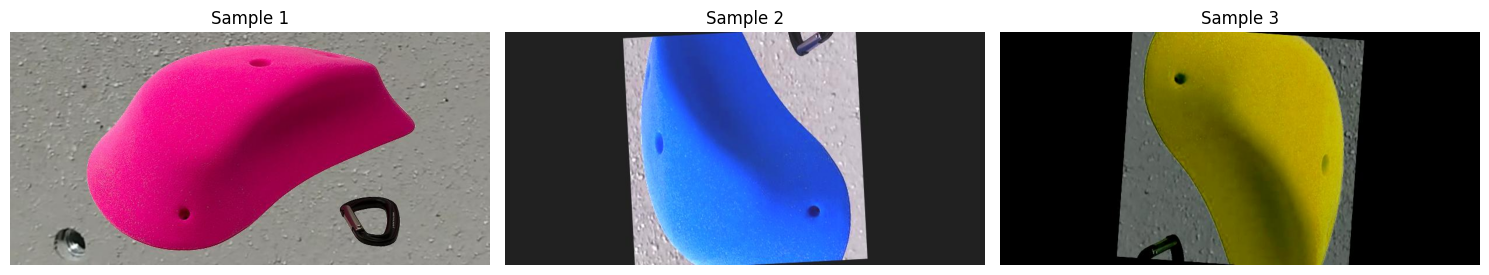


Training model...
Starting directory: c:\Users\koryc\OneDrive\Pulpit\V-Aid-Climbing\ML-hold-detection
Changing to YOLOv5 directory from c:\Users\koryc\OneDrive\Pulpit\V-Aid-Climbing\ML-hold-detection
Executing: python train.py --img 640 --batch 16 --epochs 2 --data c:\Users\koryc\OneDrive\Pulpit\V-Aid-Climbing\ML-hold-detection\Climbing-Holds-and-Volumes-14\data.yaml --weights yolov5s.pt --cache


In [ ]:
ROBOFLOW_API_KEY = "707o5pzSw4QE2tm1xBnx"
import os
# Go up one level to the parent directory
os.chdir('..')
print(f"Current working directory: {os.getcwd()}")

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("blackcreed-xpgxh").project("climbing-holds-and-volumes")
version = project.version(14)
dataset = version.download("yolov5")
                

results = run_climbing_hold_detection(
    api_key=ROBOFLOW_API_KEY,
    epochs=2,  # Reduce for faster training
    train_new_model=True
)